In [2]:
import gym
import numpy as np
from gym import error, spaces, utils, Env
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Descripción del problema

El siguiente ejemplo consiste en un Ambiente (Room). La temperatura de la habitación cambia debido a la temperatura externa ambiente (se asume de forma desconocida). La habitación cuenta con un equipo de Aire Acondicionado controlado por un Agente. El objetivo de este Agente es mantener la temperatura en 0 grados. El Aire Acondicionado puede cambiar la temperatura en 0, 1, 2 o 3 grados ya sea frío o calor.

# Ambiente

El ambiente (Room) está simulado por el siguiente código

In [3]:
class Room(Env):
    
    def __init__(self):
        self.observation_space = spaces.Box(low=-20, high=40, shape=(), dtype=np.float32)
        self.action_space = spaces.Discrete(7, start=-3)
                  
    def reset(self):
        self.step_count = 0
        self.initial_random = self.observation_space.sample()
        self.external_temp = 0
        self.external_temp = self._temp_variation()
        self.temp = self.external_temp
        return self.temp
    
    def step(self, action):
        delta_temp = self._temp_variation()
        self.external_temp += delta_temp
        self.temp += delta_temp + action
        self.step_count += 1
        return self.temp

    def _temp_variation(self):
        x = self.initial_random + self.step_count
        return np.float64('%.2f'%(20 * np.sin(x/10))) - self.external_temp 
          

# Test Room

In [4]:
env = Room()

In [5]:
env.observation_space

Box(-20.0, 40.0, (), float32)

In [6]:
env.observation_space.sample()

array(4.400487, dtype=float32)

In [7]:
env.action_space

Discrete(7, start=-3)

In [8]:
env.action_space.sample()

-3

In [25]:
env.reset()

-5.28

# Reflex Agente

Esta es la implementación de un Agente Reflejo Simple, que dada la observación (temperatura de la habitación), toma una acción de enfriar o calentar en 0, 1, 2 o 3 grados. El agente solo enfría o calienta si la temperatura difiere en más de 2 grados.

In [15]:
class AgentReflex():

    def lookup(self, obs):
        if obs > 9:
            return -3
        elif obs > 5:
            return -2
        elif obs > 2:
            return -1
        elif obs < -9:
            return 3
        elif obs < -5:
            return 2
        elif obs < -1:
            return 1
        else:
            return 0

# Test Reflex

In [16]:
agent = AgentReflex()

In [17]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 100

In [18]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.lookup(obs)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: 17.53 
 Prev. Obs: 17.53 -> Action: -3 -> Room: 14.530000000000001
External: 17.53 
 Prev. Obs: 14.530000000000001 -> Action: -3 -> Room: 12.41
External: 18.41 
 Prev. Obs: 12.41 -> Action: -3 -> Room: 10.100000000000001
External: 19.1 
 Prev. Obs: 10.100000000000001 -> Action: -3 -> Room: 7.59
External: 19.59 
 Prev. Obs: 7.59 -> Action: -2 -> Room: 5.899999999999999
External: 19.9 
 Prev. Obs: 5.899999999999999 -> Action: -2 -> Room: 4.0
External: 20.0 
 Prev. Obs: 4.0 -> Action: -1 -> Room: 2.8999999999999986
External: 19.9 
 Prev. Obs: 2.8999999999999986 -> Action: -1 -> Room: 1.6099999999999994
External: 19.61 
 Prev. Obs: 1.6099999999999994 -> Action: 0 -> Room: 1.120000000000001
External: 19.12 
 Prev. Obs: 1.120000000000001 -> Action: 0 -> Room: 0.4400000000000013
External: 18.44 
 Prev. Obs: 0.4400000000000013 -> Action: 0 -> Room: -0.4299999999999997
External: 17.57 
 Prev. Obs: -0.4299999999999997 -> Action: 0 -> Room: -1.4699999999999989
External: 16.53 
 Prev. Ob

# Graficando los resultados

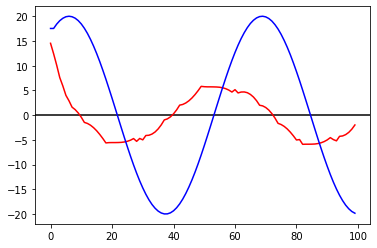

In [19]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

# Métrica de Performance
Una posible métrica de performance, podría ser ver la temperatura media del ambiente con la acción del agente.

In [20]:
print("Temperatura media con el agente: ", np.mean(agent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Temperatura media con el agente:  -0.38750000000000057
Temperatura media sin el agente:  1.3777000000000001


Otra posible métrica de performance, es evaluar para cada instante de tiempo (step) cuanto difiere la temperatura obtenida de la objetivo=0. Esto se puede hacer con mean_squared_error o mean_absolute_error. 
Comparemos la métrica obtenida por el agente contra la métrica obtenida sin un agente:

In [21]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, agent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

Variación media con el agente:  4.1021
Variación media sin el agente:  13.0727


# Ejercicio: Model (Goal / Utility) Based Agent 

Construir un Agente basado en un modelo. 

Esto es: 

    - Construir un modelo a mano, por ejemplo un grafo, con estados y transiciones [Ver figura].    
    - Discretizar las observaciones devueltas por el ambiente mapeándolas a un estado.    
    - Tomar una decisón basada en el estado.    
    - Definir un objetivo y una utilidad

Por ejemplo, el Agente podría conocer un modelo que tiene 2 estados {Frío, Calor}

<img src="Modelo.png">


In [40]:
class State():
    def itsVeryCold(self, obs):
        return obs < -5
    def itsCold(self, obs):
        return (obs > -1) and (obs < -5)
    def itsOK(self, obs):
        return obs > -1 and obs < 1
    def itsHot(self, obs):
        return obs > 1 and obs < 5
    def itsVeryHot(self, obs):
        return obs > 5

In [41]:
class AgentModelBased():

    def lookup(self, obs):
        state = State()
        if state.itsVeryCold(obs):
            return 5
        if state.itsCold(obs):
            return 3
        if state.itsOK(obs):
            return 0
        if state.itsHot(obs):
            return -3
        return -5

In [42]:
agent = AgentModelBased()

In [43]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 100

In [44]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.lookup(obs)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: 9.86 
 Prev. Obs: 9.86 -> Action: -5 -> Room: 4.859999999999999
External: 9.86 
 Prev. Obs: 4.859999999999999 -> Action: -3 -> Room: 3.539999999999999
External: 11.54 
 Prev. Obs: 3.539999999999999 -> Action: -3 -> Room: 2.119999999999999
External: 13.12 
 Prev. Obs: 2.119999999999999 -> Action: -3 -> Room: 0.5600000000000005
External: 14.56 
 Prev. Obs: 0.5600000000000005 -> Action: 0 -> Room: 1.8499999999999996
External: 15.85 
 Prev. Obs: 1.8499999999999996 -> Action: -3 -> Room: -0.010000000000001563
External: 16.99 
 Prev. Obs: -0.010000000000001563 -> Action: 0 -> Room: 0.9600000000000009
External: 17.96 
 Prev. Obs: 0.9600000000000009 -> Action: 0 -> Room: 1.75
External: 18.75 
 Prev. Obs: 1.75 -> Action: -3 -> Room: -0.6499999999999986
External: 19.35 
 Prev. Obs: -0.6499999999999986 -> Action: 0 -> Room: -0.23999999999999844
External: 19.76 
 Prev. Obs: -0.23999999999999844 -> Action: 0 -> Room: -0.030000000000001137
External: 19.97 
 Prev. Obs: -0.030000000000001137

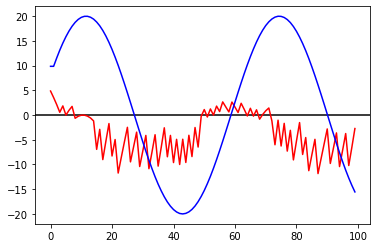

In [45]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente